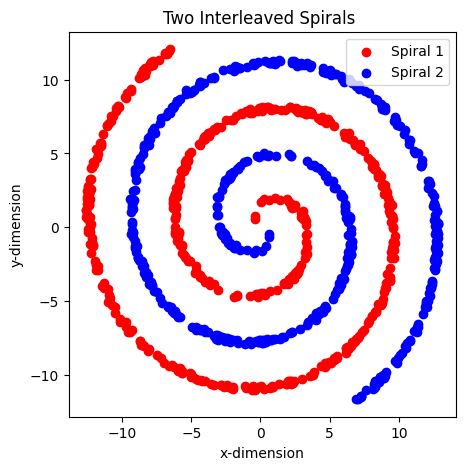

Epoch 1, Loss: 0.8275492191314697
Epoch 51, Loss: 0.636794924736023
Epoch 101, Loss: 0.6099065542221069
Epoch 151, Loss: 0.580304741859436
Epoch 201, Loss: 0.5471711158752441
Epoch 251, Loss: 0.4897722899913788
Epoch 301, Loss: 0.40360134840011597
Epoch 351, Loss: 0.302747517824173
Epoch 401, Loss: 0.20376324653625488
Epoch 451, Loss: 0.1187720075249672
Epoch 501, Loss: 0.061611954122781754
Epoch 551, Loss: 0.03424496576189995
Epoch 601, Loss: 0.021176477894186974
Epoch 651, Loss: 0.014178707264363766
Epoch 701, Loss: 0.010182795114815235
Epoch 751, Loss: 0.007674023974686861
Epoch 801, Loss: 0.005982282105833292
Epoch 851, Loss: 0.004789877682924271
Epoch 901, Loss: 0.0039276545867323875
Epoch 951, Loss: 0.0032832599245011806


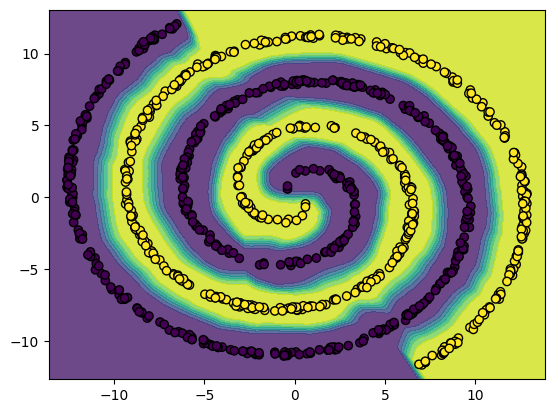

In [26]:
'''  We can include all libraries here'''
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt




def generate_spirals(number_of_points, noise):

    """
    generates two interleaved spirals
    Parameters:
        number_of_points (int): Total number of data points to generate.
        noise (float): Standard deviation of Gaussian noise added to the data.

    Returns:
        X (np.array): Spiral coordinates.
        Y (np.array): Labels (0 or 1).
    """
    n = np.sqrt(np.random.rand(number_of_points//2)) * 780 * (2 * np.pi) / 360
    d1x = -np.cos(n) * n + np.random.rand(number_of_points//2) * noise
    d1y = np.sin(n) * n + np.random.rand(number_of_points//2) * noise
    spiral_1 = np.vstack((d1x, d1y)).T

    d2x = np.cos(n) * n + np.random.rand(number_of_points//2) * noise
    d2y = -np.sin(n) * n + np.random.rand(number_of_points//2) * noise
    spiral_2 = np.vstack((d2x, d2y)).T

    X = np.vstack((spiral_1, spiral_2))
    Y = np.hstack((np.zeros(number_of_points//2), np.ones(number_of_points//2)))
    return X, Y


'''  This method is used to plot the decision boundary by using a grid as input to the model '''
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # Generate a mesh grid covering the entire feature space
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    # xx.ravel() and yy.ravel() flatten the 2D arrays into 1D arrays.
    grid = np.c_[xx.ravel(), yy.ravel()]
    '''  torch.no_grad() ensures that the operations within this block do not track gradients,
    which is important for inference (predicting without updating model parameters).'''
    with torch.no_grad():
        Z = model(torch.tensor(grid, dtype=torch.float32))
    Z = Z.reshape(xx.shape)
    # Creates a filled contour plot showing the decision boundary.
    plt.contourf(xx, yy, Z, alpha=0.8)
    # Plots the original data points, with colors indicating their true class labels y
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.show()


'''  A fully connected feedforward neural network (Multilayer Perceptron or MLP) is used here  '''
class MLPNet(nn.Module):
    ''' __init__ allows you to set up the initial state of an object by assigning values to its attributes.'''
    def __init__(self):
        ''' The super(MLPNet, self).__init__() call invokes the __init__ method
        of the parent class nn.Module.
         '''
        super(MLPNet, self).__init__()
        '''  A fully connected (dense) layer that transforms the input from 2 features to 128 features.'''
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 128)
        '''  The final fully connected layer that outputs a single value,
        suitable for binary classification. '''
        self.fc3 = nn.Linear(128, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        '''  ReLU would produce outputs in the range [0, ∞),
        while sigmoid ouputs in the range [0, 1] suitable for binary classification
        for this task only. '''
        x = torch.sigmoid(self.fc3(x))
        return x



# generate data in X and labels in Y
X, Y = generate_spirals(number_of_points=1000, noise = 0.3)

# Plot the spirals
plt.figure(figsize=(5, 5))
# When Y is 0 it is spiral 1 when Y is 1 then it is spiral 2
plt.scatter(X[Y == 0][:, 0], X[Y == 0][:, 1], color='red', label='Spiral 1')
plt.scatter(X[Y == 1][:, 0], X[Y == 1][:, 1], color='blue', label='Spiral 2')
plt.title('Two Interleaved Spirals ')
plt.xlabel('x-dimension')
plt.ylabel('y-dimension')
plt.legend()
plt.show()

# MLP model defined above
model = MLPNet()

# Binary Cross-Entropy Loss.
criterion = nn.BCELoss()
# Adam optimizer , learning rate is 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# convertX and Y to tensor to be used for DL
#  tensor should use 32-bit floating-point numbers
X_tensor = torch.tensor(X, dtype=torch.float32)
'''  view reshapes it into a 2D tensor with one column and
as many rows as needed to accommodate all the elements '''
Y_tensor = torch.tensor(Y, dtype=torch.float32).view(-1, 1)

for epoch in range(1000):
    model.train()
    ''' optimizer.zero_grad() clears the current gradients of all the parameters
    managed by the optimizer. This is necessary to ensure that each optimization
    step uses only the gradients from the current forward and backward pass,
     not the accumulated gradients from previous passes.'''
    optimizer.zero_grad()
    outputs = model(X_tensor)
    # Y_tensor is the ground truth and outputs are predictions
    loss = criterion(outputs, Y_tensor)
    '''  loss.backward() initiates the backward pass.
    PyTorch computes the gradients of the loss with respect to each parameter
    in the model by applying the chain rule of calculus.
     These gradients are stored in the .grad attribute of each parameter.
    '''
    loss.backward()
    ''' optimizer.step(), the optimizer iterates over the model parameters
    and adjusts them based on their gradients'''
    optimizer.step()

    if epoch % 50 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# plot the decision boundary to see how the model works
plot_decision_boundary(model, X, Y)